In [6]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm.notebook import tqdm
import random
from sklearn.neural_network import MLPClassifier
from collections import Counter

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
# import nltk

import utils
import copy
from sklearn import tree
import sklearn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

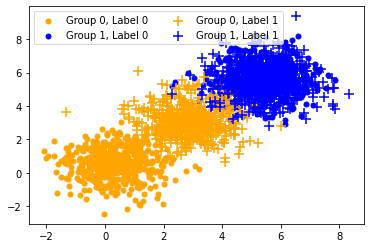

In [3]:
#Create the synthetic dataset

total=2000
X, y, groups, mu, sig = utils.getSyntheticDataset(total)

import itertools
colors = ["orange", "blue", "green", "gray"]
markers = [".", "+"]

indices = list(range(total))
random.shuffle(indices)
# indices = indices[:500]

for label, group in itertools.product(np.unique(y), np.unique(groups)):
    x1 = [X[i][0] for i in indices if y[i]==label and groups[i]==group]
    x2 = [X[i][1] for i in indices if y[i]==label and groups[i]==group]
    
    leg = "Group " + str(group) + ", Label " + str(label)
    plt.scatter(x1, x2, c=colors[group], marker=markers[label], label=leg, s=100)
plt.legend(ncol=2)

## Synthetic expert design

In [8]:
#First expert perfect on group 0 and second perfect on group 1

def getUniformExperts():
    experts = []    
    experts.append(utils.UniformExpert([0]))
    experts.append(utils.UniformExpert([1]))
    return experts


## Online training

In [12]:
experts = getUniformExperts()
NUM_EXPERTS = len(experts)
expert_costs = utils.getExpertCosts(NUM_EXPERTS, costs=[1,0.5,0])

np.random.seed(1026)

train, test = utils.getPartition(frac=0.7, total=total)
lambda_cost = 0.01
dropout = 0

input_size = 2
output_size = NUM_EXPERTS+1

random.shuffle(train)

#### Training using pre-processing algorithm

In [ ]:
reps = 2 # Number of repetitions

all_accs, clf_accs = [], []

# Variable s (and sL, sU) control the dSim function that is used to construct the deferrer prior
for s in tqdm(np.linspace(0.5, 1, 6)):
    sL = 1-s
    sU = s

    accs, c_accs = [], []
    train, test = utils.getPartition(frac=0.7, total=total)
    random.shuffle(train)

    deferrer_prior = utils.getDeferrerWithPrior_Syn(input_size, output_size, X, groups, train[:500], experts, sU, sL)                      
    train = train[500:]

    for _ in tqdm(range(reps)):
        
        deferrer, classifier = utils.train_preproc(deferrer_prior, experts, expert_costs, train, X, y, groups)
        acc, c_acc, wts = utils.test_syn(deferrer, classifier, experts, test, X, y, groups)
        accs.append(acc)
        c_accs.append(c_acc)        
        
    all_accs.append(list(accs))
    clf_accs.append(list(c_accs))    


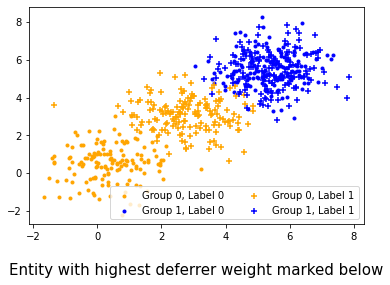

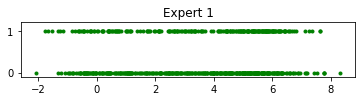

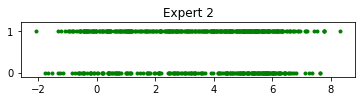

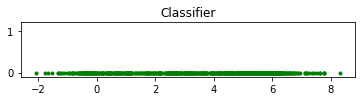

In [42]:
colors = ["orange", "blue", "green", "gray"]
markers = [".", "+"]

indices = test
random.shuffle(indices)

for label, group in itertools.product(np.unique(y), np.unique(groups)):
    x1 = [X[i][0] for i in indices if y[i]==label and groups[i]==group]
    x2 = [X[i][1] for i in indices if y[i]==label and groups[i]==group]
    
    leg = "Group " + str(group) + ", Label " + str(label)
    plt.scatter(x1, x2, c=colors[group], marker=markers[label], label=leg)
plt.legend(ncol=2)
plt.xlabel("\nEntity with highest deferrer weight marked below", fontsize=15)
plt.show()

wts = np.array(wts)
for i in range(NUM_EXPERTS+1):
    plt.figure(figsize=(6,1))
    plt.scatter(xs, wts[:,i], marker=".", color="green")
    plt.ylim([-0.1,1.2])
    plt.title("Expert "+str(i+1))
    if i == NUM_EXPERTS:
        plt.title("Classifier")
    plt.show()

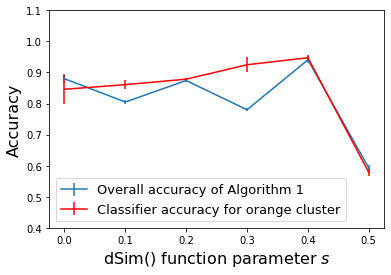

In [44]:
accs_mean, accs_std = [], []
all_accs = np.array(all_accs)
clf_accs = np.array(clf_accs)

for i, s in enumerate(np.linspace(0.5,1, 6)):
    accs_mean.append(np.mean(all_accs[i], axis=0)[0])
    accs_std.append(np.std(all_accs[i], axis=0)[0])    
    
plt.errorbar(1-np.linspace(0.5, 1, 6), accs_mean, accs_std, label = "Overall accuracy of Algorithm 1")

accs_mean, accs_std = [], []

for i, s in enumerate(np.linspace(0.5,1, 6)):
    accs_mean.append(np.mean(clf_accs[i], axis=0)[1])
    accs_std.append(np.std(clf_accs[i], axis=0)[1])    
    
plt.errorbar(1-np.linspace(0.5, 1, 6), accs_mean, accs_std, label = "Classifier accuracy for orange cluster", color="red")
plt.ylim([0.4,1.1])
plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("dSim() function parameter $s$", fontsize=16)
plt.legend(loc="lower left", fontsize=13)

#### Training using Smooth Matching algorithm

In [ ]:

reps = 2 # Number of repetitions
T = 1000
all_accs, clf_accs = [], []

for s in tqdm(np.linspace(0.5, 1, 6)):
    sL = 1-s
    sU = s

    accs, c_accs = [], []
    train, test = utils.getPartition(frac=0.7, total=total)
    random.shuffle(train)

    for _ in tqdm(range(reps)):
        deferrer = utils.getDeferrer_Syn(input_size, output_size) 
        deferrer, classifier = utils.train_smooth(deferrer, sL, sU, experts, expert_costs, train, X, y, groups, T)
        acc, c_acc, wts = utils.test_syn(deferrer, classifier, experts, test, X, y, groups)
        accs.append(acc)
        c_accs.append(c_acc)        
        
    all_accs.append(list(accs))
    clf_accs.append(list(c_accs))    



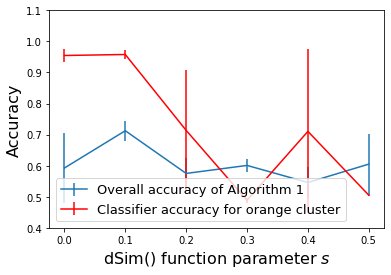

In [58]:
accs_mean, accs_std = [], []
all_accs = np.array(all_accs)
clf_accs = np.array(clf_accs)

for i, s in enumerate(np.linspace(0.5,1, 6)):
    accs_mean.append(np.mean(all_accs[i], axis=0)[0])
    accs_std.append(np.std(all_accs[i], axis=0)[0])    
    
plt.errorbar(1-np.linspace(0.5, 1, 6), accs_mean, accs_std, label = "Overall accuracy of Algorithm 1")

accs_mean, accs_std = [], []

for i, s in enumerate(np.linspace(0.5,1, 6)):
    accs_mean.append(np.mean(clf_accs[i], axis=0)[1])
    accs_std.append(np.std(clf_accs[i], axis=0)[1])    
    
plt.errorbar(1-np.linspace(0.5, 1, 6), accs_mean, accs_std, label = "Classifier accuracy for orange cluster", color="red")
plt.ylim([0.4,1.1])
plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("dSim() function parameter $s$", fontsize=16)
plt.legend(loc="lower left", fontsize=13)